In [2]:
import pandas as pd
import numpy as np
import datetime
import sqlite3
from pandas.tseries.holiday import USFederalHolidayCalendar as uscal

import requests
import json

import matplotlib.pyplot as plt
import seaborn as sns

#import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from sklearn import model_selection
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error,mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.inspection import permutation_importance

import xgboost
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import GradientBoostingRegressor

from sklearn.svm import SVR
%matplotlib inline

C:\Users\szhang\AppData\Roaming\Python\Python37\site-packages\pandas\compat\_optional.py:138: UserWarning: Pandas requires version '2.7.0' or newer of 'numexpr' (version '2.6.9' currently installed).
  warnings.warn(msg, UserWarning)


In [3]:
model_prep = pd.read_csv('Mayfair_all.csv')

In [4]:
training = model_prep[model_prep['timestamp'] < '2020-09-29 00:00:00']
testing = model_prep[model_prep['timestamp'] > '2020-10-12 00:00:00']

In [5]:
len(training), len(testing)

(3384, 5326)

### Linear Regressor 

In [6]:
# Modeling - baseline
y_train = training['interval_kWh']
X_train = training[['temp', 'pressure', 'humidity', 
                'sunlight_No', 'sunlight_Yes', 'hour']]

y_test= testing['interval_kWh']
X_test = testing[['temp', 'pressure', 'humidity', 
                'sunlight_No', 'sunlight_Yes', 'hour']]
lr = LinearRegression()
lr_mod = lr.fit(X_train, y_train)
y_pred = lr_mod.predict(X_test)
y_predt = lr_mod.predict(X_train)
mean_absolute_error(y_train, y_predt),mean_absolute_error(y_test, y_pred)

(1.4484642696650711, 4.497633725810269)

### RFC Regressor

In [71]:
regressor = RandomForestRegressor()
lr_mod = regressor.fit(X_train, y_train)
y_pred = lr_mod.predict(X_test)
y_predt = lr_mod.predict(X_train)
mean_absolute_error(y_train, y_predt),mean_absolute_error(y_test, y_pred)

(0.3039948226950348, 5.593482367254975)

### XG-Boost Regressor

In [8]:
regressor = xgboost.XGBRegressor()
lr_mod = regressor.fit(X_train, y_train)
y_pred = lr_mod.predict(X_test)
y_predt = lr_mod.predict(X_train)
mean_absolute_error(y_train, y_predt),mean_absolute_error(y_test, y_pred)

C:\Users\szhang\AppData\Roaming\Python\Python37\site-packages\xgboost\data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +
C:\Users\szhang\AppData\Roaming\Python\Python37\site-packages\xgboost\data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


(0.47273152065953467, 5.168334778124257)

### Support Vector Regressor

In [9]:
regressor = SVR()
lr_mod = regressor.fit(X_train, y_train)
y_pred = lr_mod.predict(X_test)
y_predt = lr_mod.predict(X_train)
mean_absolute_error(y_train, y_predt),mean_absolute_error(y_test, y_pred)

(1.7270077081797508, 5.6425519141792)

### Extra Tree Regressor

In [63]:
regressor = ExtraTreesRegressor()
lr_mod = regressor.fit(X_train, y_train)
y_pred = lr_mod.predict(X_test)
y_predt = lr_mod.predict(X_train)
mean_absolute_error(y_train, y_predt),mean_absolute_error(y_test, y_pred)

(0.00014751773052003423, 5.6046556154712714)

### Bagging Regressor

In [11]:
regressor = BaggingRegressor()
lr_mod = regressor.fit(X_train, y_train)
y_pred = lr_mod.predict(X_test)
y_predt = lr_mod.predict(X_train)
mean_absolute_error(y_train, y_predt),mean_absolute_error(y_test, y_pred)

(0.3975632308904651, 5.553477882087871)

### Gradient Boosting Regressor

In [12]:
regressor = GradientBoostingRegressor()
lr_mod = regressor.fit(X_train, y_train)
y_pred = lr_mod.predict(X_test)
y_predt = lr_mod.predict(X_train)
mean_absolute_error(y_train, y_predt),mean_absolute_error(y_test, y_pred)

(0.9118247606872446, 5.163894364581041)

## Further tuning & Additional Variables
**Testing models:**
- RFC
- Extra Tree

**Additional Features:**
- Season
- Temperature from the hour before
- Working day vs non-working day

### Feature Selection

In [13]:
y = model_prep['interval_kWh']
X = model_prep[['temp', 'pressure', 'humidity', 
                'sunlight_No', 'sunlight_Yes', 'hour', 'hour_before', 'workday_0', "workday_1",
               'season_Fall', 'season_Winter', 'season_Spring', 'season_Summer']]
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                    test_size=0.25, random_state=123)

In [14]:
best_features = SelectKBest(score_func=f_classif, k='all')
fit = best_features.fit(X,y)
df_scores = pd.DataFrame(fit.scores_)
df_columns = pd.DataFrame(X.columns)
feature_scores = pd.concat([df_columns, df_scores],axis=1)
feature_scores

,0,0
0,temp,21.840031
1,pressure,15.345796
2,humidity,7.132486
3,sunlight_No,8.325654
4,sunlight_Yes,8.325654
5,hour,15.122223
6,hour_before,28.384196
7,workday_0,1.174201
8,workday_1,1.174201
9,season_Fall,3.002063


In [15]:
training = model_prep[model_prep['timestamp'] < '2020-09-29 00:00:00']
testing = model_prep[model_prep['timestamp'] > '2020-10-12 00:00:00']

y_train = training['interval_kWh']
X_train = training[['temp', 'pressure', 'humidity', 
                'sunlight_No', 'sunlight_Yes', 'hour', 'hour_before', 'workday_0', "workday_1",
               'season_Fall', 'season_Winter', 'season_Spring', 'season_Summer']]

y_test= testing['interval_kWh']
X_test = testing[['temp', 'pressure', 'humidity', 
                'sunlight_No', 'sunlight_Yes', 'hour', 'hour_before', 'workday_0', "workday_1",
               'season_Fall', 'season_Winter', 'season_Spring', 'season_Summer']]

### RFC 

In [118]:
# More features for RFC
regressor = RandomForestRegressor()
lr_mod = regressor.fit(X_train, y_train)
y_pred = lr_mod.predict(X_test)
y_predt = lr_mod.predict(X_train)
mean_absolute_error(y_train, y_predt),mean_absolute_error(y_test, y_pred)

(0.3040841513002354, 5.62380893428464)

In [119]:
training['pred_usage'] = y_predt
testing['pred_usage'] = y_pred

C:\Users\szhang\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\Users\szhang\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


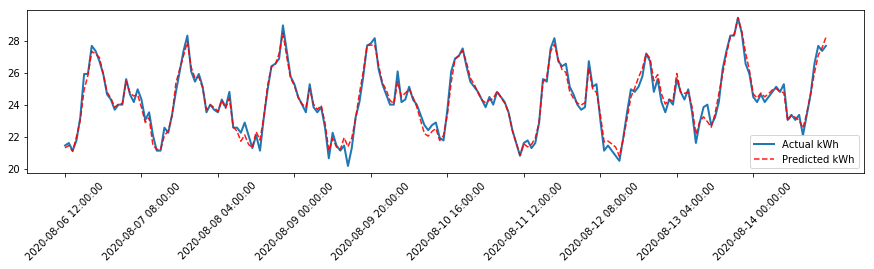

In [124]:
# Sample visualization for RFC results on training dataset
plt.figure(figsize=(15,3))
plt.plot(training['timestamp'][2100:2300], training['interval_kWh'][2100:2300], linewidth = 2, label = 'Actual kWh')
plt.plot(training['timestamp'][2100:2300], training['pred_usage'][2100:2300], alpha=0.9, color = 'r', linestyle = '--', label = 'Predicted kWh')
plt.xticks(training['timestamp'][2100:2300:20], rotation = 45)
plt.legend()

### Extra Trees

## Visualization
- Lav to do: actual vs prediction graphs to demonstrate model accuracy
- Lav to do: saving visualization

In [125]:
# More features for RFC
regressor = ExtraTreesRegressor()
lr_mod = regressor.fit(X_train, y_train)
y_pred = lr_mod.predict(X_test)
y_predt = lr_mod.predict(X_train)
mean_absolute_error(y_train, y_predt),mean_absolute_error(y_test, y_pred)

(9.550827425564668e-05, 5.6295064784078095)

### Permutation Importance - Extra Tree
result = permutation_importance(regressor, X_test, y_test, n_repeats=10,
                                random_state=42, n_jobs=2)
sorted_idx = result.importances_mean.argsort()

fig, ax = plt.subplots(figsize=(15, 10))
ax.boxplot(result.importances[sorted_idx].T,
           vert=False, labels=X_test.columns[sorted_idx])
ax.set_title("Permutation Importances - test")
fig.tight_layout()

### Overall:
- Extra Tree performs slightly better on testing set but with a bit of overfitting issues
- Extra Tree is performing close to perfect for training set

In [126]:
training['pred_usage'] = y_predt
testing['pred_usage'] = y_pred

C:\Users\szhang\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\Users\szhang\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


C:\Users\szhang\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1377: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
C:\Users\szhang\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\axes\_base.py:237: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
C:\Users\szhang\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\axes\_base.py:239: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


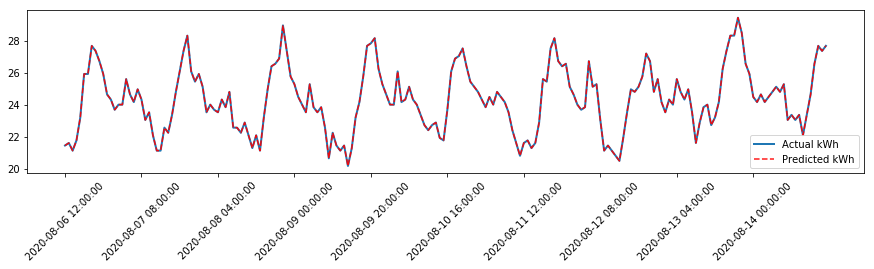

In [127]:
# Sample visualization for Extra Tree results on training dataset
plt.figure(figsize=(15,3))
plt.plot(training['timestamp'][2100:2300], training['interval_kWh'][2100:2300], linewidth = 2, label = 'Actual kWh')
plt.plot(training['timestamp'][2100:2300], training['pred_usage'][2100:2300], alpha=0.9, color = 'r', linestyle = '--', label = 'Predicted kWh')
plt.xticks(training['timestamp'][2100:2300:20], rotation = 45)
plt.legend()

### Saving calculation using extra trees

In [21]:
bills = pd.read_csv('Mayfair Court Bills.csv')
bills.columns

Index(['meter_uid', 'utility', 'utility_service_id', 'utility_billing_account',
       'utility_service_address', 'utility_meter_number',
       'utility_tariff_name', 'bill_start_date', 'bill_end_date', 'bill_days',
       'bill_statement_date', 'bill_total_kWh', 'bill_total', 'source',
       'updated', 'bill_volume', 'bill_total_unit',
       'Winter Usage On Peak_cost', 'Winter Usage On Peak_kwh',
       'Winter Usage Super Off Peak_cost', 'Winter Usage Super Off Peak_kwh',
       'Winter Usage Off Peak_cost', 'Winter Usage Off Peak_kwh',
       'Demand_cost', 'Demand_kw', 'pge_details_baseline_territory',
       'pge_details_net_generation', 'pge_details_serial',
       'pge_details_consumption', 'pge_details_rotating_outage_block',
       'Winter Usage Part Peak_cost', 'Winter Usage Part Peak_kwh',
       'supplier_1_total_cost', 'supplier_1_service_id', 'supplier_1_tariff',
       'supplier_1_total_volume', 'supplier_1_name', 'supplier_1_type',
       'supplier_1_total_unit', 'S

In [22]:
bill = bills[['bill_start_date', 'bill_end_date', 'bill_days',
       'bill_total_kWh', 'bill_total', 'bill_volume',  'Demand_cost', 'Demand_kw']]

In [23]:
bill.head(10)

,bill_start_date,bill_end_date,bill_days,bill_total_kWh,bill_total,bill_volume,Demand_cost,Demand_kw
0,03/23/2021,04/22/2021,30,12824.32,2031.69,12824.32,430.44,30.08
1,02/22/2021,03/23/2021,29,12674.32,2790.83,12674.32,439.95,30.08
2,01/21/2021,02/22/2021,32,14109.36,2944.02,14109.36,394.79,29.44
3,12/21/2020,01/21/2021,31,14531.52,2892.81,14531.52,407.95,30.72
4,11/19/2020,12/21/2020,32,15069.92,2721.12,15069.92,399.60,30.72
5,10/21/2020,11/19/2020,29,13762.48,2795.77,13762.48,489.18,30.72
6,09/21/2020,10/21/2020,30,15623.04,3680.66,15623.04,708.40,35.20
7,08/20/2020,09/21/2020,32,19798.48,4631.19,19798.48,758.25,34.56
8,07/21/2020,08/20/2020,30,17573.28,4238.56,17573.28,758.25,34.56
9,06/22/2020,07/21/2020,29,16467.04,4001.29,16467.04,744.20,33.92


In [24]:
# include the midnight of the first day
# greater and equal to for the time bound

In [25]:
testing_bill3 = testing[(testing['timestamp'] >= "2020-12-21 00:00:00") & (testing['timestamp'] < "2021-01-21 00:00:00")]
testing_bill2 = testing[(testing['timestamp'] >= "2021-01-21 00:00:00") & (testing['timestamp'] < "2021-02-22 00:00:00")]
testing_bill1 = testing[(testing['timestamp'] >= "2021-02-22 00:00:00") & (testing['timestamp'] < "2021-03-23 00:00:00")]
testing_bill0 = testing[(testing['timestamp'] >= "2021-03-23 00:00:00") & (testing['timestamp'] < "2021-04-22 00:00:00")]
training_bill7 = training[(training['timestamp'] >= "2020-08-20 00:00:00") & (training['timestamp'] < "2020-09-21 00:00:00")]
training_bill8 = training[(training['timestamp'] >= "2020-07-21 00:00:00") & (training['timestamp'] < "2020-08-20 00:00:00")]

In [27]:
sum(testing_bill3.interval_kWh), sum(testing_bill3.pred_usage)

(14531.520000000011, 18085.734448000017)

In [28]:
sum(testing_bill2.interval_kWh), sum(testing_bill2.pred_usage)

(13645.519999999995, 18115.145936000004)

In [29]:
sum(testing_bill1.interval_kWh), sum(testing_bill1.pred_usage)

(12674.320000000005, 16561.403999999988)

In [30]:
sum(testing_bill0.interval_kWh), sum(testing_bill0.pred_usage)

(12824.32000000001, 16983.032800000015)

In [31]:
sum(training_bill7.interval_kWh), sum(training_bill7.pred_usage)

(19798.479999999963, 19798.479999999967)

In [32]:
sum(training_bill8.interval_kWh), sum(training_bill8.pred_usage)

(17573.279999999995, 17573.2656)